# Closed kinematic chain hopper, using minimal coordinates

In [1]:
import sympy as sp, numpy as np
from sympy import Matrix as Mat

%load_ext autoreload
%autoreload 2
import physical_education as pe

vec = lambda *args: sp.Matrix(args)
simplify = lambda m: pe.utils.parsimp(m, nprocs=2, f=sp.simplify)

## Define variables and constants

In [2]:
constants = mb, mu, ml, rb, ru, rl, g = sp.symbols('m_b m_u m_l r_b r_u r_l g', real=True)
constants_mapping = dict(zip(constants, (4.1, 0.090, 0.090, 0.15, 0.1375, 0.250, 9.81)))

full_simp = lambda x: simplify(x.subs(constants_mapping).evalf())

Ib, Iu, Il = mb*(rb**2 + rb**2)/12, (mu*ru**2)/12, (ml*rl**2)/12
# Ib = 0

# two input torques
τl, τr = sp.Matrix(sp.symbols('\\tau_:2', real=True))

u = vec(τl, τr)

# two ground reaction forces
Lx, Ly = sp.symbols('L_x L_y', real=True)

In [3]:
# the states of the leg
def sym_and_derivs(symbol: str):
    return sp.symbols(r'%s \dot{%s} \ddot{%s}' % (symbol, symbol, symbol))

# xb, dxb, ddxb = sym_and_derivs('x')
# yb, dyb, ddyb = sym_and_derivs('y')
xb = dxb = ddxb = yb = dyb = ddyb = 0

# thb, dthb, ddthb = sym_and_derivs('\\theta_b')
thul, dthul, ddthul = sym_and_derivs('\\theta_{ul}')
thur, dthur, ddthur = sym_and_derivs('\\theta_{ur}')

q   = vec(  thul,   thur)
dq  = vec( dthul,  dthur)
ddq = vec(ddthul, ddthur)
Bu  = vec(    τl,     τr)

# q, dq, ddq, Bu

In [4]:
def time_derivative(vector: sp.Matrix, state=vec(*q, *dq), state_deriv=vec(*dq, *ddq)):
    return vector.jacobian(state) @ state_deriv

def time_derivative_matrix(matrix: sp.Matrix, *args):
    n,m = matrix.shape
    return time_derivative(matrix.reshape(n*m, 1), *args).reshape(n,m)

## Find positions

In [5]:
def get_lower_leg_eqns():
    th_ll_TMP, th_lr_TMP = sp.symbols('th_ll th_lr')

    a = thul - thur
    b = thur + (180 - th_lr_TMP)
    c = th_ll_TMP + (180 - thul)
    d = 360 - (a + b + c)

    thll, thlr = sp.solve([
        b - c,
        sp.Eq(
            2*ru**2 * (1 - sp.cos(a)),
            2*rl**2 * (1 - sp.cos(d))
        )
    ], (th_ll_TMP, th_lr_TMP))[0]
    
    dthll, dthlr = vec(thll, thlr).jacobian([thul, thur]) @ vec(dthul, dthur)
    
    return simplify(vec(thll, thlr, dthll, dthlr))

In [6]:
thll, thlr, dthll, dthlr = get_lower_leg_eqns()

In [7]:
# the base
Pb_I = Mat([xb, yb])
Rb_I = pe.utils.rot(0).T
# Rb_I = pe.utils.rot(thb).T

# connection between base and top links
conn_b = Pb_I

conn_ls = conn_b #+ Rb_I @ Mat([-rb/2, 0])
conn_rs = conn_b #+ Rb_I @ Mat([ rb/2, 0])

# the top links (shoulder to knee)
Pul_ul = Mat([0, -ru/2])
Rul_I = pe.utils.rot(thul).T
Pul_I = sp.trigsimp(conn_ls + Rul_I @ Pul_ul)

conn_lk = conn_ls + Rul_I @ Mat([0, -ru])

Pur_ur = Mat([0, -ru/2])
Rur_I = pe.utils.rot(thur).T
Pur_I = sp.trigsimp(conn_rs + Rur_I @ Pur_ur)

conn_rk = conn_rs + Rur_I @ Mat([0, -ru])

# the bottom links (knee to foot)
Pll_ll = Mat([0, -rl/2])
Rll_I = pe.utils.rot(thll).T
Pll_I = sp.trigsimp(conn_lk + Rll_I @ Pll_ll)

conn_lf = conn_lk + Rll_I @ Mat([0, -rl])

Plr_lr = Mat([0, -rl/2])
Rlr_I = pe.utils.rot(thlr).T
Plr_I = sp.trigsimp(conn_rk + Rlr_I @ Plr_lr)

conn_rf = conn_rk + Rlr_I @ Mat([0, -rl])

## Define energies and calculate parts of manipulator equation

In [8]:
# calculate the system's kinetic and potential energy
Ps = [Pb_I, Pul_I, Pur_I, Pll_I, Plr_I]
Rs = [Rb_I, Rul_I, Rur_I, Rll_I, Rlr_I]
dths = [dthul, dthur] #dq[2:]
Is = [  Ib,    Iu,    Iu,    Il,    Il]
ms = [  mb,    mu,    mu,    ml,    ml]

dxy = [P.jacobian(q) @ dq for P in Ps]

Ek = sp.trigsimp(sum(
    0.5*m*(dx**2 + dy**2) + 0.5*I*dth**2
        for m, I, (dx, dy), dth in zip(ms, Is, dxy, dths)
))

Ep = sp.trigsimp(sum(
    m*g*y for m, (_, y) in zip(ms, Ps)
))

In [9]:
# manipulator equation parts: mass matrix, coriolis, gravity/NC force
M, C, G = pe.utils.manipulator_equation(vec(Ek), vec(Ep), q, dq)

M = simplify(M)
G = simplify(G)

In [10]:
# contact
def getfoot():
    from sympy import sin, cos, sqrt
    th1 = thul
    th2 = thur
    l1 = ru
    l2 = rl
    diff = (th1 - th2)/2
    body = l1 * cos(diff) + sqrt(l2**2 - l1**2 * sin(diff)**2)
    s = (th1 + th2)/2
    return vec(body * cos(s), body * sin(s))

foot = getfoot()
J_L = foot.jacobian(q)
L = vec(Lx, Ly)

In [11]:
# # we don't actually calculate the equations of motion
# dynamics = (
#     M @ ddq + C + G - B - J_L.T @ L
# ).subs(constants_mapping).evalf()

# dynamics = pe.utils.parsimp(dynamics, nprocs=4, f=sp.trigsimp)
# dynamics = pe.utils.parsimp(dynamics, nprocs=4, f=sp.simplify)

# dynamics

## Define foot in polar coordinates $\left(r,~\theta \right)$

This is a "virtual leg" of sorts

In [12]:
th1 = thul
th2 = thur
rp = ru * sp.cos((th1-th2)/2) + sp.sqrt(rl**2 - ru**2 * sp.sin((th1-th2)/2)**2)
#rp = sp.simplify(sp.sqrt(conn_rf[1]**2 + conn_rf[0]**2))
#thp = sp.atan2(conn_rf[1], conn_rf[0])
thp = (thul + thur)/2

foot_polar = vec(rp, thp)
foot_polar

⎡                                        _____________________________________
⎢      ⎛\theta_{ul}   \theta_{ur}⎞      ╱   2     2    2⎛\theta_{ul}   \theta_
⎢rᵤ⋅cos⎜─────────── - ───────────⎟ +   ╱  rₗ  - rᵤ ⋅sin ⎜─────────── - ───────
⎢      ⎝     2             2     ⎠   ╲╱                 ⎝     2             2 
⎢                                                                             
⎢                             \theta_{ul}   \theta_{ur}                       
⎢                             ─────────── + ───────────                       
⎣                                  2             2                            

______⎤
{ur}⎞ ⎥
────⎟ ⎥
    ⎠ ⎥
      ⎥
      ⎥
      ⎥
      ⎦

# Impedance control

First, we decide on an output $y$ to control. We could choose $y = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix}$ to control leg angles, or $y = \begin{bmatrix} r \\ \theta \end{bmatrix}$ to control the position of the foot in polar coordinates

-----

Next, we differentiate the output $y = f(q)$ until we get to the "control input" level. In mechanical systems, this is at the acceleration level, after differentiating twice: $$\ddot{y} = f(q, \dot{q}, \ddot{q})$$ because $\ddot{q}$ is a function of $u$, but $q$ and $\dot{q}$ aren't

In [13]:
# y = vec(thul, thur)
y = foot_polar

dy = simplify(time_derivative(y))

ddy = simplify(time_derivative(dy))

y, dy, ddy

⎛                                                                             
⎜                                                                             
⎜⎡                                        ____________________________________
⎜⎢      ⎛\theta_{ul}   \theta_{ur}⎞      ╱   2     2    2⎛\theta_{ul}   \theta
⎜⎢rᵤ⋅cos⎜─────────── - ───────────⎟ +   ╱  rₗ  - rᵤ ⋅sin ⎜─────────── - ──────
⎜⎢      ⎝     2             2     ⎠   ╲╱                 ⎝     2             2
⎜⎢                                                                            
⎜⎢                             \theta_{ul}   \theta_{ur}                      
⎜⎢                             ─────────── + ───────────                      
⎜⎣                                  2             2                           
⎜                                                                             
⎜                                                                             
⎝                                                   

Now, let $$\ddot{y} = f(q, \dot{q}, \ddot{q}) = v$$ where $v$ is a pseudo control input. Setting $v$ will set the "dynamics" ($\ddot{y}$) of our output - for example, we could make it behave like a spring-damper system by controlling it with a PD controller: $$v = k_p e + e_d \dot{e}$$ where $e = v_{setpoint} - v$. Bear in mind that $v = \ddot{y}$ is essentially a double integrator $\left( \frac{1}{s^2} \right)$

-----

So we know how to calculate $v$, which determines $\ddot{y}$. The next step is to map that to the _actual_ control inputs ($u$), which we do in two stages:

First, solve $\ddot{y} = v = f(q, \dot{q}, \ddot{q})$ for $\ddot{q}$, where $v$ is calculated as above

Doing that the naive/simple way (as in `sp.solve(ddy - ddysetpoint, ddthul, ddthur)`) takes aaaages, but we can speed things up by noticing that

$$\dot{y} = J_y ~ \dot{q}$$
$$\ddot{y} = J_y ~ \ddot{q} + \dot{J}_y ~ \dot{q}$$
where $J_y$ is the Jacobian of $y$ with respect to $q$, and $\dot{J}_y$ is the time derivative of $J_y$

Solving:
$$ \ddot{q} = J_y^{-1} (\ddot{y} - \dot{J}_y ~ \dot{q})$$

We can do this symbolically in this example, but if doing so isn't possible for a given system, the steps from here onwards can be done numerically (ie calculate `ddq = J_y \ (ddy - dJy @ dq)`)

In [14]:
Jy = simplify(y.jacobian(q))
dJy = simplify(time_derivative_matrix(Jy))

In [15]:
ddysetpoint = ddrs, ddths = vec(*sp.symbols(f'ddr_setpoint ddth_setpoint'))

# the line below is the same as `Jy.inv() @ (ddy - dJy * dq)`, but faster
ddq_eqn = full_simp(
    Jy.solve(ddysetpoint - dJy * dq)
)

# should only contain these symbols
assert ddq_eqn.free_symbols.issubset({thul, dthul, thur, dthur, ddrs, ddths})

ddq_eqn

──────────────────────────────────
                                                                              
597⋅sin(\theta_{ul} - \theta_{ur}) + 0.00101101077962424⋅sin(2⋅\theta_{ul} - 2
                                                                              
                                                                              
                              2                                               
653395286822⋅\dot{\theta_{ur}} ⋅(0.17820324005891⋅cos(\theta_{ul} - \theta_{ur
                                                                              
──────────────────────────────────────────────────────────────────────────────
_{ur}⎞                        ⎛3⋅\theta_{ul}   3⋅\theta_{ur}⎞                 
─────⎟ + 0.170264141367037⋅sin⎜───────────── - ─────────────⎟ + 0.007939098691
     ⎠                        ⎝      2               2      ⎠                 

                                2                                             
50314584132038⋅\

In [16]:
# sp.count_ops(Jy) + sp.count_ops(ddysetpoint - dJy * dq), sp.count_ops(ddq_eqn)

In [17]:
# # test:
# ddy_test = simplify(
#     Jy@ddq + dJy@dq
# )
# should_equal_zero = simplify(sp.trigsimp(sp.expand(
#     ddy_test - ddy
# )))
# assert all(expr == 0 for expr in should_equal_zero)

Next, we solve the equations of motion ($M\ddot{q} + C\dot{q} + G = B u + Q + A^T F$) to get $u$

Again, to do this performantly, we should solve the `Ax=b` version: $B \tau = M\ddot{q} + C\dot{q} + G - Q - J_L^T L$

_However_, since our system has $B = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$, we can just calculate $\tau = M\ddot{q} + C\dot{q} + G - Q - J_L^T L$ directly

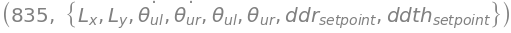

In [18]:
torque_input = full_simp(
    M @ ddq_eqn + C + G - J_L.T @ L
)

sp.count_ops(torque_input), torque_input.free_symbols

The ODrive does [current control, not torque control](https://docs.odriverobotics.com/#current-control) (although that's changing [in a new version](https://github.com/madcowswe/ODrive/blob/v0.5.1-rc5/Firmware/odrive-interface.yaml#L955)). For now we need to map current to torque via a torque constant $K_t$

In [19]:
Kt = sp.Symbol('Kt')
current_input = 1/Kt * torque_input

Great - calculate `current_input` and we're done. We could lambdify a function (which should be fast enough -- see timing below) but if it isn't, it could be worth using `numba`:
- https://numba.readthedocs.io/en/stable/user/5minguide.html
- https://numba.readthedocs.io/en/stable/reference/aot-compilation.html)

In [23]:
current_input.shape

In [26]:
test

In [27]:
current_lambdified = sp.lambdify(
    [ddrs, ddths, thul, thur, dthul, dthur, Lx, Ly, Kt],
    (current_input[0], current_input[1]))

test = current_lambdified(1., 2., 3., 4., 5., 6., 7., 8., 9.)
assert isinstance(test, tuple) and all(isinstance(t, float) for t in test)

Otherwise we can just write the function to disk:

In [28]:
cm = constants_mapping
pycode = f"""# generated by impedance-control.ipynb
import math, typing

def impedance_control(
        ddr_setpoint: float, ddth_setpoint: float,
        th_ul: float, th_ur: float,
        dth_ul: float, dth_ur: float,
        L_x: float, L_y: float,
        Kt: float
    ) -> typing.Tuple[float,]:
    \"\"\"
    Masses and lengths:
    mb = {cm[mb]:.3f}kg, mu = {cm[mu]:.3f}kg, ml = {cm[ml]:.3f}kg
    rb = {cm[rb]:.3f} m, ru = {cm[ru]:.3f} m, rl = {cm[rl]:.3f} m, g = {cm[g]:.3f}m/s^2
    
    Kt is the torque constant
    \"\"\"
    current_input = (
        {sp.pycode(current_input[0])},
        {sp.pycode(current_input[1])},
    )
    return current_input
""".replace('\\theta_','th_').replace('{', '').replace('}', '').replace(r'\dot', 'd')

with open('scripts/controller_generated.py', 'w') as f:
    f.write(pycode)

# print(pycode)

In [30]:
from scripts.controller_generated import impedance_control
import math

test_input = np.random.random(9)

for lamb, disk in zip(current_lambdified(*test_input), impedance_control(*test_input)):
    if not math.isclose(lamb, disk):
        print('got different values:', lamb, disk, lamb-disk, test_input)

In [34]:
from timeit import timeit

N = 1000

tlambdify = timeit('current_lambdified(1.,2.,3.,4.,5.,6.,7.,8.,9.)',
                   number=N, globals=globals())/N
twritetodisk = timeit('impedance_control(1.,2.,3.,4.,5.,6.,7.,8.,9.)',
                      number=N, globals=globals())/N

print(f'lambdify: {tlambdify*1000} ms | write to disk: {twritetodisk*1000} ms')

lambdify: 0.23500619100013864 ms | write to disk: 0.027268278998235473 ms


and that's that! Writing to disk is much faster

In [ ]:
# def getb():
#     fr = Rl_I @ vec(0, -Fr)
#     rr = Pl_I
#     Qr = (fr.T @ rr.jacobian(q)).T

#     fth = Mat([Fth])
#     rth = Mat([thb-thl])
#     Qth = (fth.T @ rth.jacobian(q)).T

#     return Qr + Qth

# B = getb().jacobian(u)

In [ ]:
# # Jacobian and time derivative
# A = foot.jacobian(q)  # or: conn_rf, conn_lf
# dA = time_derivative_matrix(A)
# # dA = sp.zeros(*A.shape)

# # constraint forces
# # Mi = M.inv()
# # λ = -(A @ Mi @ A.T).inv() * (A @ Mi @ (B + Q - C - G) + dA @ dq)
# # λ = -inv(A*inv(M)*transpose(A))*(A*inv(M)*(B + Q - C - G) + dA*dq)
# # λ = sp.simplify(λ)

# # eqn = M@ddq + C + G - B - Q - A.T*λ
# # eqn = sp.simplify(eqn)

# A#, dA

In [ ]:
# # sp.init_printing(wrap_line=True) #     num_columns: int or None

# # B_ = B.jacobian(u)
# # B_inv = sp.inv_quick(B_.T @ B_) @ B_.T

# assert B_inv @ B_ == Mat([[1, 0], [0, 1]])